In [ ]:
#imports 
import numpy as np 
import pandas as pd 

import torch 
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt 

In [ ]:
train_dataset = FashionMNIST(root = ".", train = True, transform = transforms.ToTensor(), download = True)
test_dataset = FashionMNIST(root = ".", train = False, transform = transforms.ToTensor(), download = True)

In [2]:
# this function compute the output of a convultion layer.
def conv_output_shape(h_w, kernel_size= 3, stride=1, pad=1, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w
result = conv_output_shape((16, 16))
print(result)

(32, 32)


In [ ]:
# number of classes
k = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [ ]:
# Define the model
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
      nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
      nn.Dropout(0.2),
      nn.Linear(128 * 2 * 2, 512),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, K)
    )
  
  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out


In [ ]:
# The same model! Using "Flatten"
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K)   
# )

In [ ]:
model = CNN(k)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
#loading the data with dataloaders
batch_size = 128
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6501,       Test Loss: 0.4706, Duration: 0:00:07.117512
Epoch 2/15, Train Loss: 0.4275,       Test Loss: 0.3998, Duration: 0:00:06.953450
Epoch 3/15, Train Loss: 0.3643,       Test Loss: 0.3573, Duration: 0:00:07.180037
Epoch 4/15, Train Loss: 0.3277,       Test Loss: 0.3317, Duration: 0:00:07.241182
Epoch 5/15, Train Loss: 0.3018,       Test Loss: 0.3178, Duration: 0:00:07.252051
Epoch 6/15, Train Loss: 0.2768,       Test Loss: 0.3032, Duration: 0:00:07.082098
Epoch 7/15, Train Loss: 0.2597,       Test Loss: 0.2973, Duration: 0:00:06.861112
Epoch 8/15, Train Loss: 0.2436,       Test Loss: 0.2887, Duration: 0:00:06.867855
Epoch 9/15, Train Loss: 0.2288,       Test Loss: 0.2874, Duration: 0:00:06.868787
Epoch 10/15, Train Loss: 0.2145,       Test Loss: 0.2874, Duration: 0:00:07.078152
Epoch 11/15, Train Loss: 0.2054,       Test Loss: 0.2838, Duration: 0:00:07.018796
Epoch 12/15, Train Loss: 0.1927,       Test Loss: 0.2872, Duration: 0:00:07.090689
Epoch 13/15, 

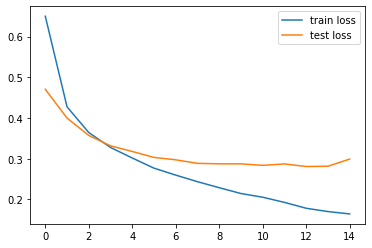

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9555, Test acc: 0.9009


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 87  97  98  95 110 114  95  97 105 102]
 [ 99 110  90 103  98  91 101  97 109 102]
 [117  81 102 106  97  93 100 102 102 100]
 [ 81 110  86  99 112 114 106 108  90  94]
 [ 89 103  89 103  93 104 117 104 106  92]
 [104  92  91  98 121  92 107  98  99  98]
 [ 93  99  84  96 113 108  90 119 103  95]
 [ 96  92 111  93 117  82 103 115 100  91]
 [ 97 103 115  92 107 112 110  86  87  91]
 [ 99 108  97 115 100 109  84  93  96  99]]


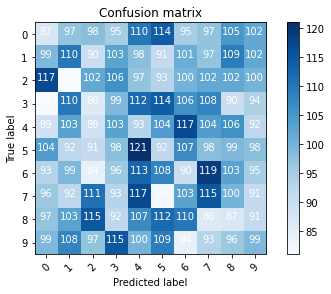

In [ ]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

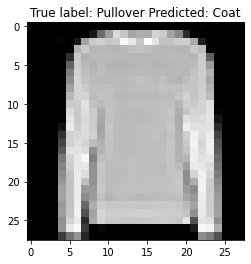

In [ ]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));